In [1]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets, plotting, image
from nilearn.maskers import NiftiMapsMasker
from sklearn.decomposition import FastICA
import pandas as pd
import tarfile
import gzip

Netmat matricies Data file: **Data/HCP/HCP_PTN1200/netmats_3T_HCP1200_MSMAll_ICAd100_ts2.tar.gz**

- 1003 subjects
- For time series (4800 total timepoints)

In [2]:
hcp_file = 'Data/netmats_3T_HCP1200_MSMAll_ICAd100_ts2.tar.gz'

In [3]:
# Read Network Matricies
data_raw = []

with gzip.open(hcp_file, 'rb') as gz_file:
    with tarfile.open(fileobj=gz_file, mode='r') as tar:
        
        # Extract a text file
        for file in tar.getnames():
            if file.endswith('.txt'):
                # Read the content and load it into a NumPy array
                subjects = np.loadtxt(tar.extractfile(file), dtype=float)
                
                ICAd = int(np.sqrt(subjects.shape[1]))
                
                # Convert into matrix
                matrix = np.array([np.reshape(i, (ICAd, ICAd)) for i in subjects])
                data_raw.append(matrix)

In [4]:
data_raw[0].shape

(1003, 100, 100)

In [5]:
data_raw[1].shape

(1003, 100, 100)

1. netmats1: Using "full" normalized temporal correlation between every node timeseries and every other. This is a common approach and is
very simple, but it has various practical and interpretational disadvantages [Smith 2012].

In [6]:
net_mat1 = data_raw[0]
net_mat1[0]

array([[ 0.     , -1.5323 , 35.936  , ...,  0.80711,  4.5279 ,  4.9836 ],
       [-1.5323 ,  0.     , -9.1569 , ...,  0.52657,  3.277  ,  1.7371 ],
       [35.936  , -9.1569 ,  0.     , ..., -0.67059,  0.22134, -0.87813],
       ...,
       [ 0.80711,  0.52657, -0.67059, ...,  0.     ,  1.2762 ,  3.6853 ],
       [ 4.5279 ,  3.277  ,  0.22134, ...,  1.2762 ,  0.     ,  4.497  ],
       [ 4.9836 ,  1.7371 , -0.87813, ...,  3.6853 ,  4.497  ,  0.     ]])

2. netmats2: Using partial temporal correlation between nodes' timeseries. This aims to estimate direct connection strengths better than
achieved by full correlation. To slightly improve the estimates of partial correlation coefficients, a small amount of L2 regularization is
applied (setting rho=0.01 in the Ridge Regression netmats option in FSLNets) [Smith OHBM 2014, FSLNets].

In [7]:
net_mat2 = data_raw[1]
net_mat2[0]

array([[ 0.     ,  0.61676,  9.5727 , ...,  0.38609, -0.18148,  2.4279 ],
       [ 0.61676,  0.     ,  2.856  , ..., -0.7748 , -0.43767, -1.0479 ],
       [ 9.5727 ,  2.856  ,  0.     , ...,  0.34688, -0.34526, -1.2173 ],
       ...,
       [ 0.38609, -0.7748 ,  0.34688, ...,  0.     , -0.30947,  3.0171 ],
       [-0.18148, -0.43767, -0.34526, ..., -0.30947,  0.     ,  0.26007],
       [ 2.4279 , -1.0479 , -1.2173 , ...,  3.0171 ,  0.26007,  0.     ]])

In [8]:
id_file = 'Data/IDs/subjectIDs.txt'
id_recon1_file = 'Data/IDs/subjectIDs_recon1.txt'
id_recon2_file = 'Data/IDs/subjectIDs_recon2.txt'

In [9]:
# Read Subject IDs
subject_IDs = np.loadtxt(id_file, dtype=int)

In [10]:
subject_IDs.shape

(1003,)

In [11]:
# Read Subject Descriptions
subject_data = pd.read_csv('Data/subjects.csv', index_col = 'Subject')

In [12]:
subject_data.head()

,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
Subject,,,,,,,,,,,,,,,,,,,,,
100004,S900,Q06,M,22-25,False,0,0,0,0.0,False,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
100206,S900,Q11,M,26-30,True,1,1,4,100.0,True,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
100307,Q1,Q01,F,26-30,True,1,1,4,100.0,True,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
100408,Q3,Q03,M,31-35,True,1,1,4,100.0,True,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
100610,S900,Q08,M,26-30,True,2,1,4,100.0,True,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88


In [13]:
subject_data = subject_data[['Gender', 'Age']]
subject_data.head()

,Gender,Age
Subject,,
100004,M,22-25
100206,M,26-30
100307,F,26-30
100408,M,31-35
100610,M,26-30


In [14]:
net_mat2[0]

array([[ 0.     ,  0.61676,  9.5727 , ...,  0.38609, -0.18148,  2.4279 ],
       [ 0.61676,  0.     ,  2.856  , ..., -0.7748 , -0.43767, -1.0479 ],
       [ 9.5727 ,  2.856  ,  0.     , ...,  0.34688, -0.34526, -1.2173 ],
       ...,
       [ 0.38609, -0.7748 ,  0.34688, ...,  0.     , -0.30947,  3.0171 ],
       [-0.18148, -0.43767, -0.34526, ..., -0.30947,  0.     ,  0.26007],
       [ 2.4279 , -1.0479 , -1.2173 , ...,  3.0171 ,  0.26007,  0.     ]])

In [15]:
# Combine the netmats and id data in data frame
net_mat_data = pd.Series(dict(zip(subject_IDs, net_mat2))).to_frame().rename(columns = {0 : 'netmat'})
net_mat_data

,netmat
100206,"[[0.0, 0.61676, 9.5727, -5.4959, 0.34639, 3.00..."
100307,"[[0.0, -0.29664, 17.317, -9.0467, -0.28723, 1...."
100408,"[[0.0, 1.6486, 6.6189, -8.8877, 1.4337, 1.006,..."
100610,"[[0.0, -0.90275, 7.7215, -8.3907, 3.3144, 2.93..."
101006,"[[0.0, -0.088768, 9.4979, -10.412, 1.0646, 4.3..."
...,...
992673,"[[0.0, -0.11536, 7.1338, -5.5322, 0.34004, 1.6..."
992774,"[[0.0, 0.25353, 8.0265, -6.2072, 4.1589, 1.582..."
993675,"[[0.0, -1.0378, 10.709, -3.3224, -0.090704, 2...."
994273,"[[0.0, 0.64613, 11.471, -5.5137, 1.9357, 4.259..."


In [16]:
# Now merge the two lists
data = subject_data.join(net_mat_data, how = 'right')

In [17]:
data.head()

,Gender,Age,netmat
100206,M,26-30,"[[0.0, 0.61676, 9.5727, -5.4959, 0.34639, 3.00..."
100307,F,26-30,"[[0.0, -0.29664, 17.317, -9.0467, -0.28723, 1...."
100408,M,31-35,"[[0.0, 1.6486, 6.6189, -8.8877, 1.4337, 1.006,..."
100610,M,26-30,"[[0.0, -0.90275, 7.7215, -8.3907, 3.3144, 2.93..."
101006,F,31-35,"[[0.0, -0.088768, 9.4979, -10.412, 1.0646, 4.3..."


## Vizualization

Using NetMat 2

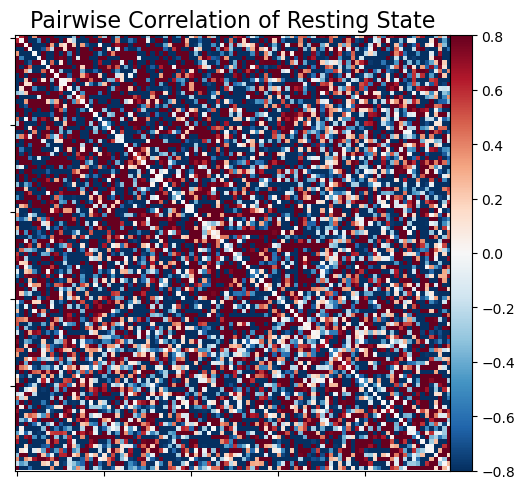

In [18]:
# Visualize the correlation matrix
plotting.plot_matrix(
    net_mat2[0], colorbar=True, vmax=0.8, vmin=-0.8, title = "Pairwise Correlation of Resting State")

## Exploratory Analysis

## Andrew's Data